<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

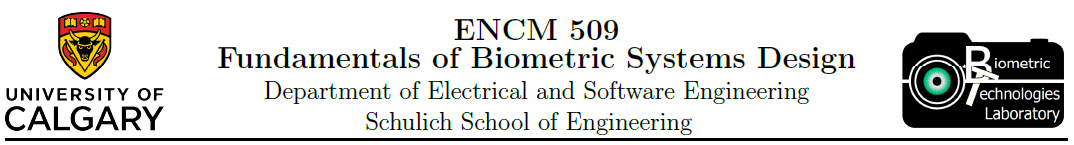

<center>
    <h1>Laboratory Experiment #5</h1>
    <h3>Fingerprint Biometrics - Part II: Matching</h3>
</center>

In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.patches import Rectangle
import matplotlib as mpl

from scipy import ndimage as ndi

from sklearn.feature_extraction.image import extract_patches_2d

from skimage.io import imread, imsave
from skimage.util import img_as_ubyte, invert
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median, gaussian
from skimage.filters import gabor_kernel
from skimage.util import invert
from skimage.exposure import equalize_adapthist

# custom functions
from utils_encm.blockproc import blockproc
from utils_encm.poincare import calculate_singularities
from utils_encm.segmentation import segmentation
from utils_encm.normalization import normalize
from utils_encm.gabor_filter import gabor_filter
from utils_encm.frequency import ridge_freq
from utils_encm.orientation import calculate_angles, visualize_angles
from utils_encm.crossing_number import calculate_minutiae
from utils_encm.skeletonize import skeletonize
from utils_encm.align2 import align2
from utils_encm.MatchGaborFeat import MatchGaborFeat
from utils_encm.align2 import align2
from utils_encm.match import match

# setting the default colormap for images only
mpl.rc('image', cmap='gray')

## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
2. (10 marks) Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section).
3. Conclusion (a paragraph on what is the main take-out of the lab).

## Introduction

**This Lab is a continuation of Lab 4 and its purpose is to focus on two fingerprint matching algorithms; the Minutiae count based matching and the Gabor feature-based matching. The fingerprint data used for this Lab was previously collected during Lab 4 and includes a total of 40 fingerprint images, 10 from Ali's right thumb, 10 from Ali's left thumb, 10 from Ahmed (Anwar's) right thumb and 10 from Ahmed (Anwar's) left index finger. Firstly, this lab will look at the effect of varying the anngle and frequency of a Gabor filter on the extracted features. Then we are going to compare the performance of Minutiae based matching compared with Gabor feature based matching on the same data. Finally, we will look at how well minutiae based matching can identify the correct fingerprint from 10 other false (impostor) fingerprints.**

**PART II (Lab 5): Specific Questions** 

A detailed description of each exercise to be included in your report (10 marks total) is given below:

- **Exercise 1** (1 mark): Use the demo file to perform the Gabor filtering for ridge detection on your fingerprint image, while adjusting the parameters `frequency` and `angle` of the filter. Choose two different values for each of those parameters, one at a time, and visually evaluate the results. What is the impact of  changing the parameters of the Gabor filtering results (visually)? Draw the conclusions.

**In exercise 1 we will be finding out the effects of changing the frequency and angle paramaters of a Gabor filter on the extracted features. We will use an original filter with angle=45 degrees and frequency = 0.11. For the second filter we will change the angle to -45 degrees, and for the third filter we will change the frequency to 0.22.**

In [2]:
def gabor_filtering(img, fi):
    # 'mode' specifies how the convolution algorithm will deal with the borders
    If1 = equalize_adapthist(ndi.convolve(img, fi, mode='wrap'))
    # normalize
    If1 = ((If1 - np.min(If1)) / (np.max(If1) - np.min(If1))) * 255
    #print(np.min(If1), np.max(If1))
    
    return If1

# create the filter according to the size of the image
def gabor_template(im, angle, freq=0.11):
    r, c = im.shape
    ysize = int(np.floor(r/10))

    t = int(np.floor(ysize/8))
    fi = np.real(gabor_kernel(freq, theta=angle, n_stds=t))
    
    return fi

Text(0.5, 1.0, 'Image processed')

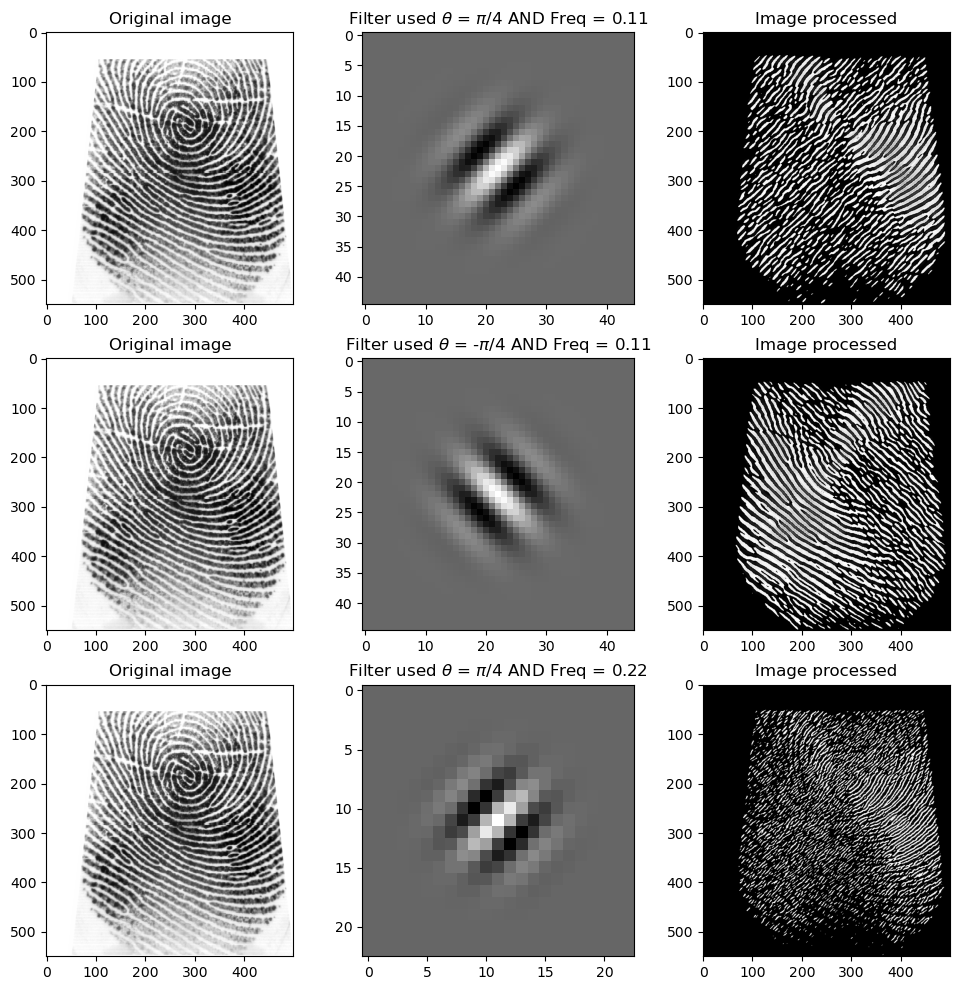

In [3]:
img = img_as_ubyte(imread('fingerprints/ali_right/5.bmp', as_gray=True))

fi_1 = gabor_template(img, angle=np.pi/4, freq=0.11)
img_f1 = gabor_filtering(img, fi_1)

fi_2 = gabor_template(img, angle=-np.pi/4, freq=0.11)
img_f2 = gabor_filtering(img, fi_2)

fi_3 = gabor_template(img, angle=np.pi/4, freq=0.22)
img_f3 = gabor_filtering(img, fi_3)

plt.figure(figsize=(12, 12))
plt.subplot(3,3,1)
plt.imshow(img, cmap='gray'); plt.title('Original image')
plt.subplot(3,3,2)
plt.imshow(fi_1, cmap='gray'); plt.title(r'Filter used $\theta$ = $\pi$/4 AND Freq = 0.11')
plt.subplot(3,3,3)
plt.imshow(img_f1, cmap='gray'); plt.title('Image processed')
plt.subplot(3,3,4)
plt.imshow(img, cmap='gray'); plt.title('Original image')
plt.subplot(3,3,5)
plt.imshow(fi_2, cmap='gray'); plt.title(r'Filter used $\theta$ = -$\pi$/4 AND Freq = 0.11')
plt.subplot(3,3,6)
plt.imshow(img_f2, cmap='gray'); plt.title('Image processed')
plt.subplot(3,3,7)
plt.imshow(img, cmap='gray'); plt.title('Original image')
plt.subplot(3,3,8)
plt.imshow(fi_3, cmap='gray'); plt.title(r'Filter used $\theta$ = $\pi$/4 AND Freq = 0.22')
plt.subplot(3,3,9)
plt.imshow(img_f3, cmap='gray'); plt.title('Image processed')

## Exercise 1 Analysis

**Changing the angle emphasises/extracts the lines/skeletons that are facing that angle from the original fingerprint. In the first example, the angle is 45 degrees, meaning that the filter emphasises the lines that are oriented in the +45 degree direction, which is on the right side of the fingerprint image. Likewise, changing the angle to -45 degrees emphasises on the lines going in the -45 degree direction as seen in the 2nd set of figures, which happens to be on the left side of the fingerprint image. Increasing the frequency (3rd set of images) emphasises the area of the fingerprint image that has higher frequencie (i.e., the skeleton lines are closer together).**

- **Exercise 2** (3 marks): Use 9 of your fingerprints as a database, or a gallery. Use the remaining one as a  probe. The database of 9 templates (feature vectors) represents the same "individual".

    - Develop a simple identification procedure (use loops that repeat 1 to 1 matching several times), to  match  a probed fingerprint of your finger (e.g. left thumb) against 9 different impressions of the same   finger. Use the Jupyter notebook `Lab04Fingerprint1.ipynb` that performs 1 to 1 matching. 
        
    - Record the scores (use a table - see the first Lab on Markdown how to do a table in Jupyter notebooks) for the **minutiae based matching**. Note that for this type of matching, the higher the score the better the match.

    - Record the number of matches against the same fingers (True Positives - TP), and the number of mismatches against the same fingers (False Negatives - FN). How the choice of the threshold affects the  matching? Use the numbers or graphs to illustrate your answer.

**In exercise 2, we are going to analye the minutiae matching algorithm. We are going to look at the scores generated when a probe image is compared with 9 test images from the same finger. Then we will select a threshold and calculate the rates. After that, we are going to change the threshold and analyze what changing the threshold does to the performance of the system.**

In [6]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

In [4]:
images = []
for i in range(1, 10):
    image_path_string = 'fingerprints/ali_right/' + str(i) + '.bmp'
    images.append(img_as_ubyte(imread(image_path_string, as_gray=True)))

test_image = img_as_ubyte(imread('fingerprints/ali_right/10.bmp', as_gray=True))

Fps = []
for i in range(0, 9):
    Fps.append(fingerprint_processing(images[i], block_size=12, threshold=0.1))

test_fp = fingerprint_processing(test_image, block_size=12, threshold=0.1)

scores = []
for i in range(0, 9):
    imSkeletonAlign, minutiaArrayAlign = align2(Fps[i], test_fp)
    test_fp['imSkeletonAlign'] = imSkeletonAlign
    test_fp['minutiaArrayAlign'] = minutiaArrayAlign
    match_threshold = 6
    score = match(Fps[i], test_fp, threshold2=match_threshold)
    scores.append(score)
    print()

number of matched minutiae: 71
distance total computed : 316
number of minutiae in input image: 2942
number of minutiae in database image: 473

number of matched minutiae: 117
distance total computed : 512
number of minutiae in input image: 2969
number of minutiae in database image: 444

number of matched minutiae: 130
distance total computed : 558
number of minutiae in input image: 2969
number of minutiae in database image: 558

number of matched minutiae: 94
distance total computed : 404
number of minutiae in input image: 2969
number of minutiae in database image: 560

number of matched minutiae: 75
distance total computed : 357
number of minutiae in input image: 2942
number of minutiae in database image: 790

number of matched minutiae: 60
distance total computed : 302
number of minutiae in input image: 2542
number of minutiae in database image: 598

number of matched minutiae: 77
distance total computed : 335
number of minutiae in input image: 2969
number of minutiae in database im

In [10]:
TP = 0
FN = 0

threshold = np.mean(scores) - np.std(scores)
print("Match Threshold is %.4f\n" % (threshold))

for i in range(0, 9):
    print('Score for Image %d vs. Probe Image: %.4f' % (i, scores[i]))
    if( scores[i] >= threshold ):
        TP += 1
    else:
        FN += 1

print()
print("Number of True Positives: %d" % (TP))
print("Number of False Negatives: %d" % (FN))

Match Threshold is 0.0397

Score for Image 0 vs. Probe Image: 0.0416
Score for Image 1 vs. Probe Image: 0.0686
Score for Image 2 vs. Probe Image: 0.0737
Score for Image 3 vs. Probe Image: 0.0533
Score for Image 4 vs. Probe Image: 0.0402
Score for Image 5 vs. Probe Image: 0.0382
Score for Image 6 vs. Probe Image: 0.0463
Score for Image 7 vs. Probe Image: 0.0800
Score for Image 8 vs. Probe Image: 0.0482

Number of True Positives: 8
Number of False Negatives: 1


## Exercise 2 Analysis

| Image | Score | True Positive | False Negative |
| :-: | :-: | :-: | :-: |
| 1 | 0.0416 | yes | no |
| 2 | 0.0686 | yes | no |
| 3 | 0.0737 | yes | no |
| 4 | 0.0533 | yes | no |
| 5 | 0.0402 | yes | no |
| 6 | 0.0382 | no | yes |
| 7 | 0.0463 | yes | no |
| 8 | 0.0800 | yes | no |
| 9 | 0.0482 | yes | no |

**From the data and the Table above we can see that using a threshold of 0.0397 yeilds a True Positive rate of 8/9 = 89% and False Negative rate of 1/9 = 11% which is very good. It is clear to see that as we increase the match threshold the True positive rate will decrease and the False Negative rate will increase. (E.g., if we set the threshold to 0.05, out TP rate will become 4/9 = 44%, and FN rate will be 5/9 = 56%)**

- **Exercise 3** (2 marks): Repeat the same experiment (using the same images) from Exercise 2, but **instead of minutiae based matching, use the method based on the Gabor filter**. Note that the lower the score, the better the match. Again, record the numbers of the True positives and False negatives.
    Compare the results of Gabor score matching with the minutiae based matching. Draw conclusions upon both experiment results.

**In exercise 3, we are going to analye the gabor filter matching algorithm. We are going to look at the scores generated when a probe image is compared with 9 test images from the same finger. Then we will select a threshold and calculate the rates. After that, we are going to change the threshold and analyze what changing the threshold does to the performance of the system.**

In [5]:
# Get a list of all image files in the directory
image_files = os.listdir('fingerprints/ali_left')

# Initialize an empty list to hold the images
images = []

# Loop over the image files
for image_file in image_files:
    # Full path to the image file
    full_path = os.path.join('fingerprints/ali_left', image_file)
    
    # Read the image file and convert to 8-bit unsigned integer format
    im = img_as_ubyte(imread(full_path, as_gray=True))
    
    # Append the image to the list
    images.append(im)

In [7]:
gab_im1 = images[0]

gabor_scores = []

for image in images:
    score = MatchGaborFeat(gab_im1, image)
    print('score for Gabor features: %.4f\n' % (score))
    gabor_scores.append(score)


score for Gabor features: 0.0000

score for Gabor features: 13.3327

score for Gabor features: 13.5080

score for Gabor features: 16.5428

score for Gabor features: 13.8086

score for Gabor features: 15.2646

score for Gabor features: 15.0680

score for Gabor features: 14.4407

score for Gabor features: 14.6872

score for Gabor features: 14.2284



In [18]:
TP_gabor = 0
FN_gabor = 0

threshold = np.mean(gabor_scores[1:]) + np.std(gabor_scores[1:])
print("Match Threshold is %.4f\n" % (threshold))

for i in range(1, 10):
    print('Score for Image %d vs. Probe Image: %.4f' % (i, gabor_scores[i]))
    if( gabor_scores[i] <= threshold ):
        TP_gabor += 1
    else:
        FN_gabor += 1

print()
print("Number of True Positives: %d" % (TP_gabor))
print("Number of False Negatives: %d" % (FN_gabor))

Match Threshold is 15.4852

Score for Image 1 vs. Probe Image: 13.3327
Score for Image 2 vs. Probe Image: 13.5080
Score for Image 3 vs. Probe Image: 16.5428
Score for Image 4 vs. Probe Image: 13.8086
Score for Image 5 vs. Probe Image: 15.2646
Score for Image 6 vs. Probe Image: 15.0680
Score for Image 7 vs. Probe Image: 14.4407
Score for Image 8 vs. Probe Image: 14.6872
Score for Image 9 vs. Probe Image: 14.2284

Number of True Positives: 8
Number of False Negatives: 1



| Image | Score | True Positive | False Negative |
| :-: | :-: | :-: | :-: |
| 1 | 13.3327 | Yes | No |
| 2 | 13.5080 | Yes | No |
| 3 | 16.5428 | No | Yes |
| 4 | 13.8086 | Yes | No |
| 5 | 15.2646 | Yes | No |
| 6 | 15.0680 | Yes | No |
| 7 | 14.4407 | Yes | No |
| 8 | 14.6872 | Yes | No |
| 9 | 14.2284 | Yes | No |

In [17]:
TP_gabor = 0
FN_gabor = 0

threshold = np.mean(gabor_scores[1:])
print("Match Threshold is %.4f\n" % (threshold))

for i in range(1, 10):
    print('Score for Image %d vs. Probe Image: %.4f' % (i, gabor_scores[i]))
    if( gabor_scores[i] <= threshold ):
        TP_gabor += 1
    else:
        FN_gabor += 1

print()
print("Number of True Positives: %d" % (TP_gabor))
print("Number of False Negatives: %d" % (FN_gabor))

Match Threshold is 14.5423

Score for Image 1 vs. Probe Image: 13.3327
Score for Image 2 vs. Probe Image: 13.5080
Score for Image 3 vs. Probe Image: 16.5428
Score for Image 4 vs. Probe Image: 13.8086
Score for Image 5 vs. Probe Image: 15.2646
Score for Image 6 vs. Probe Image: 15.0680
Score for Image 7 vs. Probe Image: 14.4407
Score for Image 8 vs. Probe Image: 14.6872
Score for Image 9 vs. Probe Image: 14.2284

Number of True Positives: 5
Number of False Negatives: 4



| Image | Score | True Positive | False Negative |
| :-: | :-: | :-: | :-: |
| 1 | 13.3327 | Yes | No |
| 2 | 13.5080 | Yes | No |
| 3 | 16.5428 | No | Yes |
| 4 | 13.8086 | Yes | No |
| 5 | 15.2646 | No | Yes |
| 6 | 15.0680 | No | Yes |
| 7 | 14.4407 | Yes | No |
| 8 | 14.6872 | No | Yes |
| 9 | 14.2284 | Yes | No |

## Exercise 3 Analysis

**For this exercise, we can see that using the same selection method (mean of the scores and then account for the standard deviation of the scores) for the threshold selection as exercise 2 results in similar performance. With the threshold set at 15.4852, we get a TP rate of 8/9 = 88.9% and an FN rate of 1/9 = 11.1% which is very good. If we change the threshold to 14.5423 (a lower value) results in a TP rate of 5/9 = 55.6% and an FN rate of 4/9 = 44.4% which is worse. In this exercise, due to the differences between minutiae matching and gabor filter matching (with gabor filter matching, a lower score means a better match), as we increase the threshold, we achieve a higher TP rate and a lower FN rate (which is the inverse of exercise 2).**

- **Exercise 4** (4 marks): Use one of your fingerprints (e.g. left thumb) to be used as the  probed one. Use the database with one  impression of the same finger and 10 of some other finger(s). Therefore, you have a database with 11 templates one of which represents the same "individual", and the rest of the templates represent another "individual(s)."
    Develop a ranking identification procedure for minutiae-based matching only. A sample of such procedure is as follows:
    - Record the matching scores for each comparison; use some index corresponding to the fingerprint number. Sort the matching scores: the top score is the maximum score for the Minutia based approach.
    - Do you have a true match?  If your true match is not on top of your ranking, which rank is it?  Use this rank's score as a "thresholding score" that separates a top-ranked group  of the closest matches from the others.
    - Record the number of matches against different fingers as False Positives, and the mismatches as True Negatives. Some False positives may belong to the top ranked group.
    - Draw the conclusions upon your experiment, such as the threshold choice etc.

**In exercise 4, we are going to use a probe fingerprint against 10 other fingerprints from a different finger and one impression from the same finger as the impression. We aim to analyze the results of the minuatiae matching algorithm and see whether we get a true match on our probe or not. Then we will analyze the impact of changing the threshold.**

In [7]:
# Get a list of all image files in the directory
image_files = os.listdir('fingerprints/anwar_right')

# Initialize an empty list to hold the images
images = []

# Loop over the image files
for image_file in image_files:
    # Full path to the image file
    full_path = os.path.join('fingerprints/anwar_right', image_file)
    
    # Read the image file and convert to 8-bit unsigned integer format
    im = img_as_ubyte(imread(full_path, as_gray=True))
    
    # Append the image to the list
    images.append(im)

# Probing image
probe_im = img_as_ubyte(imread('fingerprints/ali_left/1.bmp', as_gray=True))

# Impression image of the same finger as the probing image
impression_im = img_as_ubyte(imread('fingerprints/ali_left/2.bmp', as_gray=True))

# Append the impression image to the list
images.append(impression_im)

# fingerprint processing
Fp1 = fingerprint_processing(probe_im, block_size=12, threshold=0.1)

# loop over the images
for image in images:
    # minutiae matching
    Fp2 = fingerprint_processing(image, block_size=12, threshold=0.1)
    # Align the two fingerprints for better matching
    imSkeletonAlign, minutiaArrayAlign = align2(Fp1, Fp2)
    Fp2['imSkeletonAlign'] = imSkeletonAlign
    Fp2['minutiaArrayAlign'] = minutiaArrayAlign
    # matching
    match_threshold = 6
    score = match(Fp1, Fp2, threshold2=match_threshold)
    print('score for minutiae: %.4f\n' % (score))


number of matched minutiae: 0
distance total computed : 0
number of minutiae in input image: 0
number of minutiae in database image: 350
score for minutiae: 0.0000

number of matched minutiae: 34
distance total computed : 142
number of minutiae in input image: 1763
number of minutiae in database image: 350
score for minutiae: 0.0322

number of matched minutiae: 135
distance total computed : 643
number of minutiae in input image: 8342
number of minutiae in database image: 350
score for minutiae: 0.0311

number of matched minutiae: 144
distance total computed : 650
number of minutiae in input image: 7779
number of minutiae in database image: 350
score for minutiae: 0.0354

number of matched minutiae: 54
distance total computed : 255
number of minutiae in input image: 4206
number of minutiae in database image: 350
score for minutiae: 0.0237

number of matched minutiae: 115
distance total computed : 523
number of minutiae in input image: 4560
number of minutiae in database image: 350
score

| Image | Score | Rank | 
| :-: | :-: | :-: | 
| 1 | 0.2279 | 1 | 
| 2 | 0.0587 | 6 | 
| 3 | 0.0671 | 3 | 
| 4 | 0.0394 | 10 | 
| 5 | 0.0502 | 8 | 
| 6 | 0.0306 | 11 | 
| 7 | 0.0650 | 5 | 
| 8 | 0.0537 | 7 | 
| 9 | 0.0482 | 9 |
| 10 | 0.0678 | 2 | 
| 11 | 0.0671 | 3 | 

**Our impression image is not on top of the list, therefore, we do not have a true match. The image is tied for third place with another which means that the system is not able to identify our true match, but it was able to rank it relatively high. We will use a threshold of 0.0671 as this is the score of the impression vs probe image. Based on this threshold, we have a False Positive rate of 3/10 = 30% and a True Negative rate of 7/10 = 70% which is not great. In our case, if we increase the threshold, say to 0.0678, the system will seemingly perform better as it will seem to perform better as it will have a False Positive rate of 2/10 = 20% and a True Negative rate of 8/10 = 80%. However, the true match will be missed. Therefore, we should be careful when selecting thresholds depending on the situation.**

## Conclusion

**Over the course of this lab, we were able to find out the effect of changing the frequency and angle of the Gabor filter on the extracted features and we were able to use 2 different matching algorithms and investigate how our threshold selection impacts the performance of the system. For minutiae matching, we observed that increasing the threshold results in lower True Positive and False Negative rates. For gabor filter matching, we observed the opposite effect. This is due to the fact the with minutiae matching, a higher results in a stronger match but the opposite is true for gabor filter matching. Finally, in exercise 4, we attempted to identify a fingerprint between ones from a different finger. The minutiae matching system did a decent job at ranking our true match in a relatively high position. We observed that increasing the threshold, while it may seem like it improves the system performance (in terms of percentages), it does not ALWAYS result in an actual improvement. For example, in exercise 4, if we were to increase our threshold, we would falsely identify the impression image as a negative when in fact it is the true match**